# Como lake: Weekly inflows dataset exploration

Data obtained from the archive of *ARPA Lombardia* ([link](https://www.arpalombardia.it/Pages/Ricerca-Dati-ed-Indicatori.aspx)), we will use tables "Afflussi settimanali per bacino" for all the available years (2011-2018), expressed in $m^3 \cdot 10^6$. The data gives inflows for each lake in the region, but we are interested in just the `"MERA"` and `"ADDA PRELACUALE"` (i.e. Adda before the lake) rivers, as they represent the two main sources of water of the Como lake.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import os

from fbprophet import Prophet
import fbprophet.plot as fbp
import scipy.stats 

First, import the different datasets and build the complete one:

In [2]:
# Get the names of the files
filenames = os.listdir('data/weekly_inflows')
filenames.sort()

# Get data from the files and concatenate them in a single df
full_df = pd.DataFrame()

for name in list(filenames):
    
    # Read data
    print(name)
    df = pd.read_excel('data/weekly_inflows/'+name, 
                       skiprows = range(0,12),
                       usecols = 'A,I,J')
    
    # Remove empty rows
    df = df.dropna(axis=0, how='all') 
    
    # Split week interval into two columns (start and end week)
    # (We have to be careful because date written in 2 different ways in the files)
    if df['SETTIMANA'][0][:5] == "01/01":
        df['From'] = df['SETTIMANA'].str[:5]
        df['To']   = df['SETTIMANA'].str[-5:]
    elif df['SETTIMANA'][0][:3] == "1/1":
        df[['From','To']] = df['SETTIMANA'].str.split("-",expand=True,)
    else:
        print('\n\n There is a problem in the date format \n\n')
        
    df.drop(['SETTIMANA'], axis=1)
    df = df[['From','To','ADDA PRELACUALE','MERA']]
    
    # Convert dates strings into datetimes
    year = name[14:18]
    df['From'] = df['From'] + '/' + year
    df['To']   = df['To']   + '/' + year
    df['From'] = pd.to_datetime(df['From'], format='%d/%m/%Y')
    df['To']   = pd.to_datetime(df['To'], format='%d/%m/%Y')
    
    # Correct dates of 2014 (they are shifted of one day)
    if year == '2014':
        df['From'] -= datetime.timedelta(days=1)
        df['To']   -= datetime.timedelta(days=1)
        
    
    # Build full dataset to contain all years
    full_df = pd.concat([full_df,df]).reset_index(drop=True)
    
    
# Reset indexes of the full dataset 
# (before, indexes restart at each year) 
full_df = full_df.reset_index(drop=True)


afflussi_sett_2011.xlsx
afflussi_sett_2012.xlsx
afflussi_sett_2013.xlsx
afflussi_sett_2014.xlsx
afflussi_sett_2015.xlsx
afflussi_sett_2016.xlsx
afflussi_sett_2017.xlsx
afflussi_sett_2018.xlsx


At the moment each row represents the weekly inflows but, if a week is spanned between two moths/years, it is splitted in two entries.</br>
Now we will join those portions of weeks to have a uniform unit of time (a week).

In [3]:
# Find rows that do not represent full weeks (always in pairs)
week_len = (full_df['To'] - full_df['From'])[1:-1]
partial_weeks = week_len.index[week_len!=datetime.timedelta(days=6)][::2]

# Add inflow values between these splitted weeks
inflows = (full_df.reset_index()
                  .replace({'index': dict(zip(partial_weeks+1,partial_weeks))})
                  .groupby('index', sort=False).sum() )

# Update end-date of the first portion of these weeks
full_df['To'][partial_weeks] = full_df['To'][partial_weeks+1]

# Remove second portions of the partial weeks and add complete inflows
full_df[['ADDA PRELACUALE','MERA']] = inflows
full_df = full_df.drop(partial_weeks+1).reset_index(drop=True)


<ipython-input-3-f0be6eb5122e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_df['To'][partial_weeks] = full_df['To'][partial_weeks+1]


In [4]:
### TEST ###

# Find rows that do not represent full weeks (pairs of rows)
week_len = (full_df['To'] - full_df['From'])[1:-1]
partial_weeks = week_len.index[week_len!=datetime.timedelta(days=6)]
partial_weeks

Int64Index([], dtype='int64')

Now, each entry of our dataframe correspond to the inflows of the two rivers during a week (i.e. a period of always 7 days)

In [5]:
# Final weekly inflow dataset
full_df

,From,To,ADDA PRELACUALE,MERA
0,2011-01-01,2011-01-02,0.0,0.1
1,2011-01-03,2011-01-09,71.4,41.1
2,2011-01-10,2011-01-16,53.7,13.2
3,2011-01-17,2011-01-23,0.2,0.2
4,2011-01-24,2011-01-30,0.3,0.1
...,...,...,...,...
414,2018-12-03,2018-12-09,15.4,7.6
415,2018-12-10,2018-12-16,3.1,0.9
416,2018-12-17,2018-12-23,13.1,6.4
417,2018-12-24,2018-12-30,8.6,4.7


## Seasonality
First, let's visualize these values in a single plot:

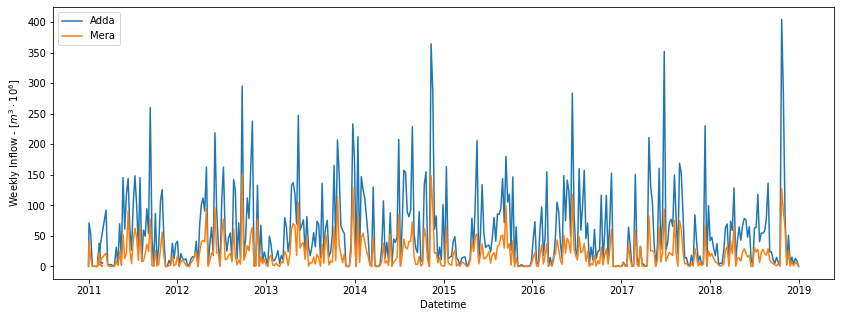

In [6]:
# Extract the two time series from the dataset
adda_inflow = full_df[['From','ADDA PRELACUALE']].set_index('From')
mera_inflow = full_df[['From','MERA']].set_index('From')

# Plot them
plt.figure(figsize=(14,5))
plt.plot(adda_inflow, label = "Adda")
plt.plot(mera_inflow, label = "Mera")
plt.xlabel('Datetime')
plt.ylabel('Weekly Inflow - [$m^3\cdot10^6$]')
plt.legend()
plt.show()

Now, I would assume that there should be a seasonal component in these values, let's see if such component can be found in the data.

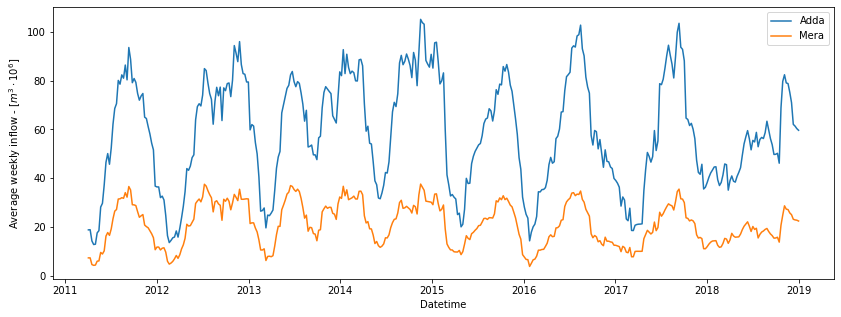

'\n# Plot residuals from this moving average\nplt.figure(figsize=(14,5))\nplt.plot(adda_inflow - adda_MA, label = "Adda")\nplt.xlabel(\'Datetime\')\nplt.ylabel(\'Noises - [$m^310^6$]\')\nplt.legend()\nplt.show()\n'

In [7]:
# Perform moving average
window_size = 15
adda_MA = adda_inflow.rolling(window_size).mean()
mera_MA = mera_inflow.rolling(window_size).mean()

# Plot filtered signals
plt.figure(figsize=(14,5))
plt.plot(adda_MA, label = "Adda")
plt.plot(mera_MA, label = "Mera")
plt.xlabel('Datetime')
plt.ylabel('Average weekly inflow - [$m^3\cdot10^6$]')
plt.legend()
plt.show()

"""
# Plot residuals from this moving average
plt.figure(figsize=(14,5))
plt.plot(adda_inflow - adda_MA, label = "Adda")
plt.xlabel('Datetime')
plt.ylabel('Noises - [$m^310^6$]')
plt.legend()
plt.show()
"""

As expected, is possible to see a seasonal component: there is a clear minimum in the inflows of both rivers during the winter (not on 2014). In order to compute how much the season impacts the inflows values, we need to model this component

Since the behaviours of the two rivers are really similar (just rescaled), keeping them separated will not provide many useful insights, so for the moment they will be summed and considered as a single streamflow.

In [26]:
# Combine inflows in a single column
full_df['inflow'] = full_df['ADDA PRELACUALE'] + full_df['MERA'] 
inflow_df = full_df.drop(['ADDA PRELACUALE','MERA'], axis=1)
inflow_df

,From,To,inflow
0,2011-01-01,2011-01-02,0.1
1,2011-01-03,2011-01-09,112.5
2,2011-01-10,2011-01-16,66.9
3,2011-01-17,2011-01-23,0.4
4,2011-01-24,2011-01-30,0.4
...,...,...,...
414,2018-12-03,2018-12-09,23.0
415,2018-12-10,2018-12-16,4.0
416,2018-12-17,2018-12-23,19.5
417,2018-12-24,2018-12-30,13.3


### Season decomposition with Prophet
Now the FB Prophet library will be used to estimate the seasonal component of the weekly inflows.

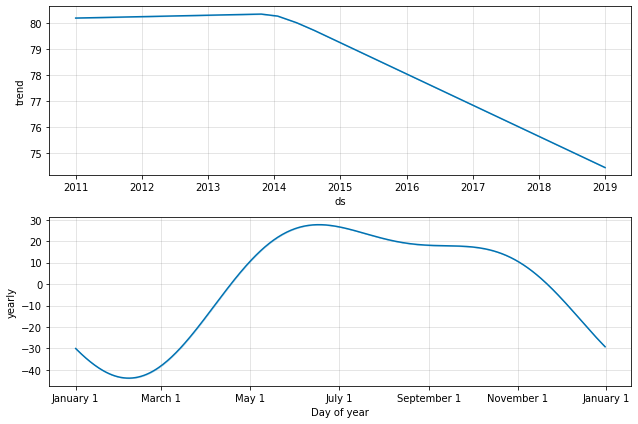

In [25]:
# format data to be compatible with the library
inflow_test = inflow_df[['From','inflow']]
inflow_test.columns = ['ds','y']
#inflow_test = inflow_test[inflow_test.y != 0]

# Find seasonality (fit it using fourier series of given order)
model = Prophet(yearly_seasonality = 2, 
                weekly_seasonality = False,
                daily_seasonality  = False,
                interval_width = 0.6827)
model.fit(inflow_test)

# Build estimated inflows
inflow_estim = model.predict()

# Plot fitted components
model.plot_components(inflow_estim)
plt.show()

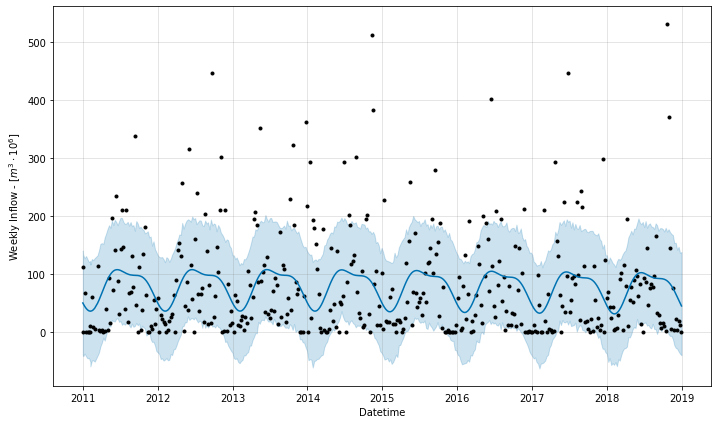

In [11]:
# Plot the estimated inflow
model.plot(inflow_estim)
plt.xlabel('Datetime')
plt.ylabel('Weekly Inflow - [$m^3\cdot10^6$]')
plt.show()

# useful data is in inflow_estim[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [12]:
# JUST A TEST WITH ANOTHER LIBRARY
"""
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(adda_inflow, model='additive', period=52)
fig = result.plot()
fig.set_size_inches(10, 8)
plt.show()"""
print()

# Time-dependent distribution for weekly inflows
We saw that there is a seasonality in the process. Now we want to obtain from the data a time-dependent distribution for the weekly inflows that depends on the period of the year, thus the distribution will be periodic. 

First of all, here I assume that each value of the inflow does not depend on the inflows of the previous week, but its distribution depends only on time. Looking at the plot with the "raw" weekly inflows I would say that successive inflows are uncorrelated, but in order to verify this assumption we will compute the auto-correlation function.

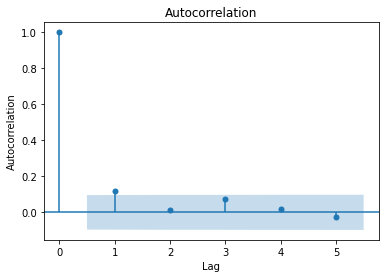

In [13]:
from statsmodels.graphics import tsaplots

# Display the autocorrelation plot of the inflows after removing seasonal component 
fig = tsaplots.plot_acf(inflow_test.y - inflow_estim.yhat, lags=5)
plt.ylabel('Autocorrelation')
plt.xlabel('Lag')
plt.show()

Weekly inflow vaues really are uncorrelated.

Since the inflow values are only positive, I would say that a safe distribution choice would be the LogNormal ([link](https://stackoverflow.com/questions/8747761/scipy-lognormal-distribution-parameters) that compares normal and lognormal fit in scipy.stats). In order to check if the distribution is valid, here I will try to fit different periods of the year:

sigma =  2.107359702172927
scale =  14.05360106707369


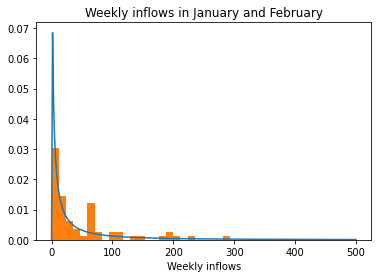

sigma =  1.687485805758922
scale =  25.77707825081582


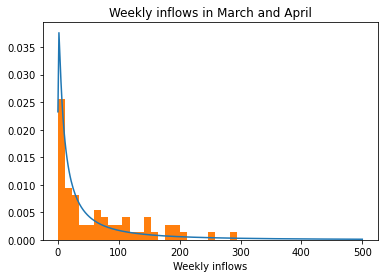

sigma =  0.7701315149723446
scale =  91.8189701185548


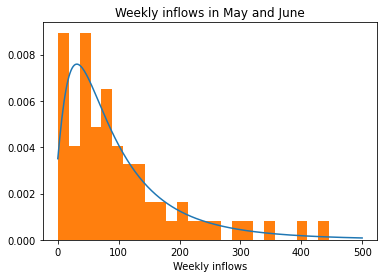

sigma =  0.4336819410385189
scale =  142.8544667996489


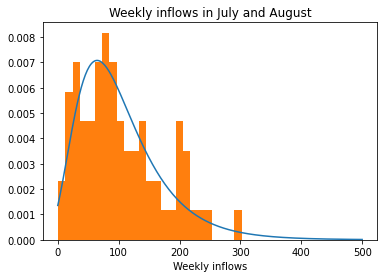

sigma =  1.275293281784454
scale =  51.18061035239094


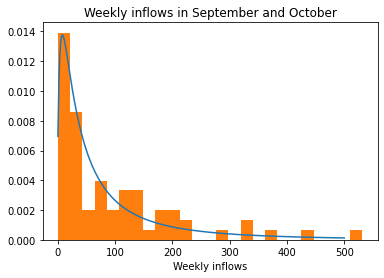

sigma =  7.322116396614602
scale =  0.5327656231920108


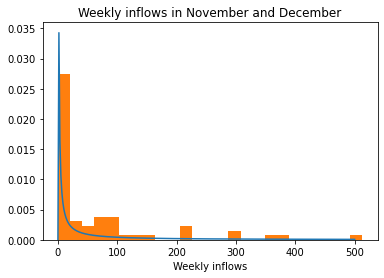

In [14]:
points = np.linspace(0.0001,500,300)
log_points = np.linspace(-2,6.5,300)

# Analize inflow distribution for a specific phase of the year
for month in range(1,13,2):
    
    # Extract dat from the considered period
    data_months = inflow_df.From.dt.month
    monthly_inflow = inflow_df[(data_months == month) | (data_months == month+1)]
    
    # Remove inflows=0.0 (they are not a lot, but ruin the fit)
    monthly_inflow = monthly_inflow[monthly_inflow.inflow != 0]
    
    # Perform the fit with a lognormal distribution
    s, loc, scale = scipy.stats.lognorm.fit(monthly_inflow.inflow, loc=0)
    lognorm_values = scipy.stats.lognorm(s, loc, scale).pdf(points)
    print('sigma = ', s)
    print('scale = ',scale)
    
    # Print results
    plt.plot(points, lognorm_values)
    plt.hist(monthly_inflow.inflow, bins=25, density=True)
    plt.title('Weekly inflows in '+ monthly_inflow.From.iloc[0].strftime("%B")
               + ' and '+ monthly_inflow.From.iloc[6].strftime("%B"))    
    plt.xlabel('Weekly inflows')
    plt.show()
    

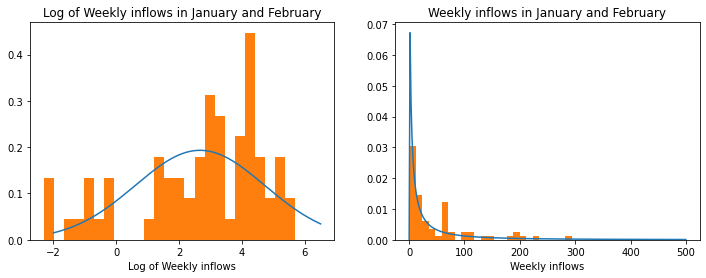

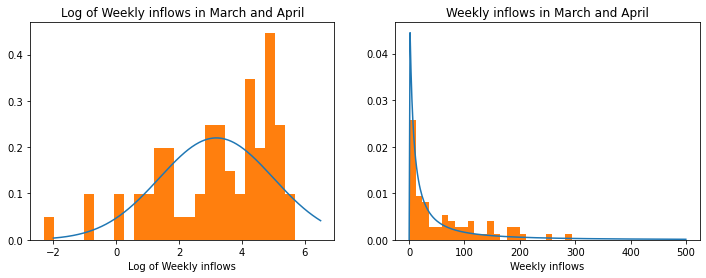

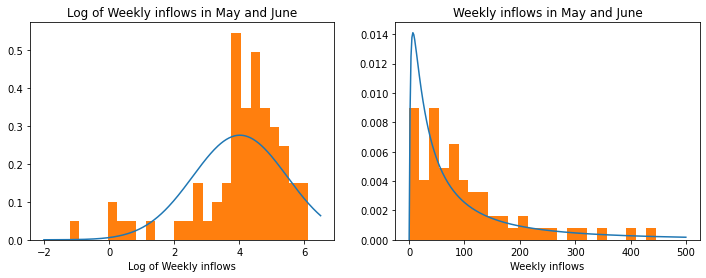

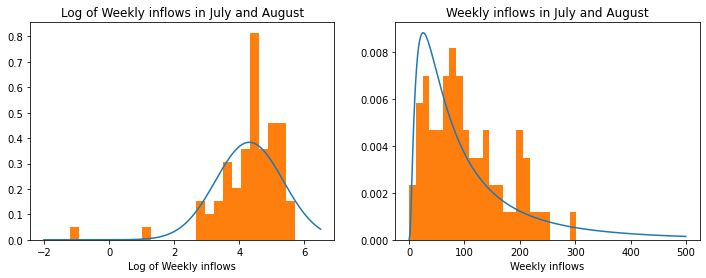

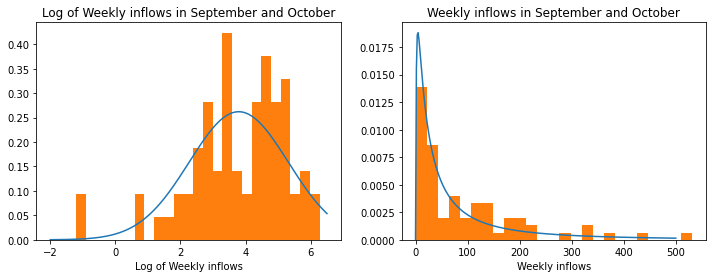

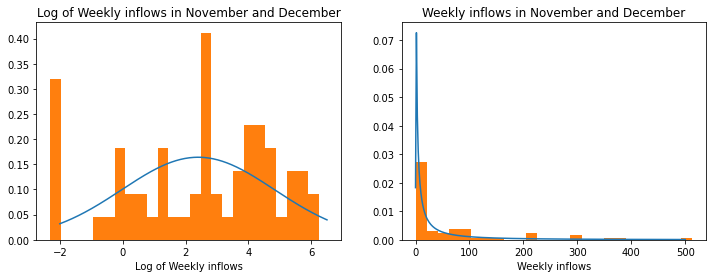

In [15]:
## HERE I TRIED TO SEE IF PERFORMING A GAUSSIAN FIT IN THE LOGARITHMIC SPACE 
## WOULD HAVE RETURNED BETTER RESULTS (BUT THERE IS NO NEED DO THIS)


log_points = np.linspace(-2,6.5,300)
points = np.linspace(0.0001,500,300)

# Analize inflow distribution for a specific phase of the year
for month in range(1,13,2):
    
    # Extract data from the considered period
    data_months = inflow_df.From.dt.month
    monthly_inflow = inflow_df[(data_months == month) | (data_months == month+1)]
    
    # Remove null inflows -> they are not a lot (11 over 419 points), but ruin the fit
    monthly_inflow = monthly_inflow[monthly_inflow.inflow != 0]
    
    # Perform the fit with a normal distribution in the log space
    mu, std = scipy.stats.norm.fit(np.log(monthly_inflow.inflow))
    norm_values = scipy.stats.norm(mu, std).pdf(log_points)

    ##### Print results #####  
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(log_points, norm_values)
    plt.hist(np.log(monthly_inflow.inflow), bins=25, density=True)
    plt.title('Log of Weekly inflows in '+ monthly_inflow.From.iloc[0].strftime("%B")
               + ' and '+ monthly_inflow.From.iloc[6].strftime("%B"))    
    plt.xlabel('Log of Weekly inflows')

    # From norm in log space to lognorm in linear space
    lognorm_values = scipy.stats.lognorm(s=std, scale=np.exp(mu)).pdf(points)
    
    plt.subplot(1, 2, 2)
    plt.plot(points, lognorm_values)
    plt.hist(monthly_inflow.inflow, bins=25, density=True)
    plt.title('Weekly inflows in '+ monthly_inflow.From.iloc[0].strftime("%B")
               + ' and '+ monthly_inflow.From.iloc[6].strftime("%B"))    
    plt.xlabel('Weekly inflows')

    plt.show()  

print()

## Use Prophet to obtain Log-normal distributions

We saw that a plausible distribution for the inflow distribution at any month could be modelled with a LogNormal, so we will use the Prophet library to obtain the distribution's features at any day.

In particular, we start by doing a season decomposition of the log values of the weekly inflows. Then when we will have the mean of the distribution and the values of its confidence interval (set to contain 68% of the values, thus corresponding to the interval $[\mu-\sigma,\mu+\sigma]$), we will return to linear space and have parameters for the LogNormal distribution at any point in time (*But we don't have to, because the Lipschtzness of the Normal distribution should be equal to the LogNormal in the linear space -> no need to solve the "conversion"*)

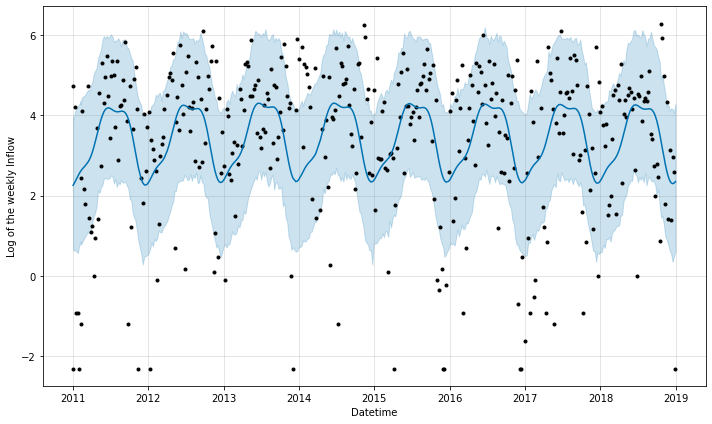

In [18]:
# format data to be compatible with the library
log_inflow_test = inflow_df[['From','inflow']][inflow_df.inflow != 0]
log_inflow_test.columns = ['ds','y']

# Since data follow Lognormal, transform them to  
# follow normal distribution in the log space
log_inflow_test.y = np.log( log_inflow_test.y ) 

# Find seasonality (fit it using fourier series of given order)
model = Prophet(yearly_seasonality = 3, 
                weekly_seasonality = False,
                daily_seasonality  = False,
                interval_width = 0.6827)
model.fit(log_inflow_test)

# Build estimated inflows
log_inflow_estim = model.predict()

# Plot fitted components
#model.plot_components(inflow_estim)
#plt.show()

# Plot the estimated inflow in the log space
model.plot(log_inflow_estim)
plt.xlabel('Datetime')
plt.ylabel('Log of the weekly Inflow')
plt.show()


From the results, we can say that the blue line represents the time-deendent average of the process and the width of the confidence interval is a good approximation of $2\sigma$ of the gaussian distribution over the inflows at each point in time. In order to measure its lipschitzness wrt to time, for each possible value of the inflow (they will be discretized), compare the values of two subsequent distribution and measure $\Delta F(inflow) / \Delta t$, and store the max value. This value is the Lipschit constant.

In [22]:
# Get gaussian parameters from the results of the fit
means  = log_inflow_estim['yhat']
sigmas = (log_inflow_estim['yhat_upper'] - log_inflow_estim['yhat_lower']) / 2

# Get values of the distributions at each point in time
discretized_inflows = np.linspace(-4,10,2000)
time_dep_distr = np.zeros((len(inflow_estim), len(discretized_inflows)))

for week in range(len(log_inflow_estim['yhat'])):
    current_gaussian = scipy.stats.norm(means[week], sigmas[week])
    time_dep_distr[week] = current_gaussian.pdf(discretized_inflows)
    
"""
# Plot Time-dependent distribution (subsequent gaussians)
plt.figure(figsize=(20,5))
plt.imshow(time_dep_distr.T, cmap='Greys', interpolation='nearest', aspect='auto')
plt.colorbar()
plt.show()
"""
print()

Now that we have estimated the time-dependent distribution, find the Lipschitz constant wrt to time. This can be done by estimating the derivative of time at each point of time for each value of the inflow (recall that time is measured as in units of weeks).

In [24]:
# Set initial Lipschitz constant and time derivative matrix
time_derivs = np.zeros((len(inflow_estim)-1, len(discretized_inflows)))
log_lip_const = 0
lin_lip_const = 0

# Compute and store values of the time derivative for each time and inflow
for i in range(len(discretized_inflows)):
    for week in range(1,len(inflow_estim['yhat'])):
        
        # Compute the derivative and check if it is the greatest (in lin and log space)
        time_derivs[week-1,i] = time_dep_distr[week,i] - time_dep_distr[week-1,i]
        if np.abs(time_derivs[week-1,i]) > log_lip_const:
            log_lip_const = np.abs(time_derivs[week-1,i])
        if time_dep_distr[week-1,i]*np.abs(time_derivs[week-1,i]) > lin_lip_const:
            lin_lip_const = time_dep_distr[week-1,i]*np.abs(time_derivs[week-1,i])
            
# Plot derivatives and result
"""plt.figure(figsize=(20,5))
plt.imshow(time_derivs.T, cmap='seismic', interpolation='nearest', aspect='auto')
plt.colorbar()
plt.show()
"""
print("The Empirical Lipschitz constant in the log-space:\n\t", log_lip_const, "1/weeks (log is adimensional)")
print("The Empirical Lipschitz constant in the linear space:\n\t", lin_lip_const, "m^3*10^6/weeks")

The Empirical Lipschitz constant in the log-space:
	 0.21698151486091624 1/weeks (log is adimensional)
The Empirical Lipschitz constant in the linear space:
	 0.04708097779133802 m^3*10^6/weeks


In order to get the Lipschitz constant of the time-dependent distribution in the linear space, we can:
* Convert the gaussian distributions in the linear space and repeat process to find lipschitzness
* Use Chain Rule of derivatives: Lipschitz constant is the max derivative wrt time, so we can say that, in the log space, we have $$L_{Log} = \max \left( \frac{d\log(p_t(s))}{dt} \right) = \max \left( \frac{d\log(p_t(s))}{dp_t(s)}\frac{dp_t(s)}{dt} \right) = \max \left( \frac{1}{p_t(s)}\frac{dp_t(s)}{dt} \right) $$ Thus we can compute $L_{Lin} = \max \left( \frac{dp_t(s)}{dt} \right)$ by repeating the same code, but multiplying each derivative of the distributions in the log-space by the term $p_t(s)$ (because at each iteration we compute the derivative of the log of the distribution).

In [92]:
# (NOT NEEDED) Plot estimated inflow in the linear space 
"""
inflow_estim[['yhat', 'yhat_lower', 'yhat_upper']] = np.exp(inflow_estim[['yhat', 'yhat_lower', 'yhat_upper']])
model.history.y = np.exp(model.history.y)

model.plot(inflow_estim)
plt.xlabel('Datetime')
plt.ylabel('Weekly Inflow - [$m^3\cdot10^6$]')
plt.show()
"""
print()